In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import simpy
import scipy.stats as st

### 1.
Using the Erlang C Formula (A. Willig, 1999), which calculates the probability of queuing we find the following:

#### M/M/2 Queue:

1. **Erlang C Formula**: 
   $$ P_w = \frac{\frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}}{\sum_{k=0}^{1} \frac{(\rho \cdot 2)^k}{k!} + \frac{(\rho \cdot 2)^2}{2!} \cdot \frac{1}{1 - \rho}} $$

2. **Average Waiting Time in Queue**:
   $$ W_q = \frac{P_w}{2\mu - \lambda} $$

3. **Total Average Time in System**:
   $$ W = W_q + \frac{1}{\mu} $$

#### M/M/1 Queue:

1. **Average Waiting Time in Queue**:
   $$ \rho' = \frac{\lambda'}{\mu} = \frac{\rho}{2} $$
   $$ W_q' = \frac{1}{\mu - \lambda'} $$

2. **Total Average Time in System**:
   $$ W' = W_q' + \frac{1}{\mu} $$

It makes sense that the queue time in a M/M/N system where $N>2$ has shorter queue times. Non-mathematically this can be thought as two supermarkets where one supermarket only has one cashier (N=1) available in comparison to the other supermarket that has two cashiers (N=2). Assuming same parameters, the supermarket with two cashiers will have higher throughput.

In [3]:
import math

def erlangC(n, rho):
    """Calculate the Erlang C formula for given n servers and system load rho."""
    numerator = (rho**n / math.factorial(n)) * (1 / (1 - rho))
    denominator = sum([(rho**k) / math.factorial(k) for k in range(n)]) + numerator
    return numerator / denominator

def mxn_queue(lambda_rate, mu, n):
    """Calculate average waiting and total time in system for M/*/n queue."""
    rho = lambda_rate / (n * mu)
    Pw = erlangC(n, rho)
    Wq = Pw / (n * mu - lambda_rate)
    return Wq, Wq + 1/mu

def mx1_queue(lambda_rate, mu):
    """Calculate average waiting and total time in system for M/*/1 queue."""
    rho = lambda_rate / mu
    Wq_prime = 1 / (mu - lambda_rate)
    return Wq_prime, Wq_prime + 1/mu

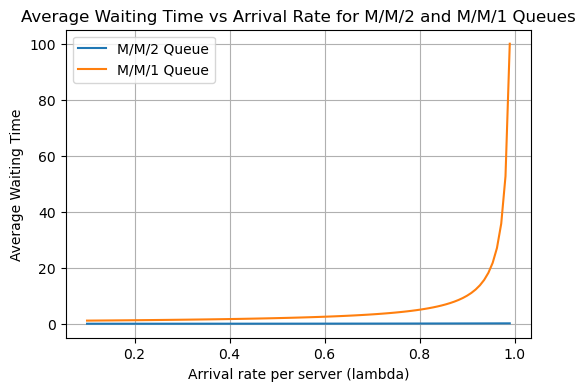

In [4]:
# Parameters
mu = 1
n = 2
lambda_rates = np.linspace(0.1, mu-0.01, 100)  # Vary lambda such that rho < 1 at all times

# Calculate waiting times for each value of lambda
waiting_times_mmn = [mxn_queue(lambda_rate, mu, n)[0] for lambda_rate in lambda_rates]
waiting_times_mm1 = [mx1_queue(lambda_rate, mu)[0] for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(lambda_rates, waiting_times_mmn, label='M/M/2 Queue')
plt.plot(lambda_rates, waiting_times_mm1, label='M/M/1 Queue')
plt.xlabel('Arrival rate per server (lambda)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Arrival Rate for M/M/2 and M/M/1 Queues')
plt.legend()
plt.grid(True)
plt.show()

### 2.
Using https://simpy.readthedocs.io/en/latest/examples/bank_renege.html tutorial code as base

In [55]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 200 
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
SIMULATIONS = 100

def source(env, number, interval, counter, wait_times, dist_src='exp', dist_cst='exp'):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, f'Customer{i:02d}', counter, wait_times, dist_cst)
        env.process(c)
        if dist_src == 'exp':
            t = random.expovariate(1.0 / interval)
        elif dist_src == 'const':
            t = interval
        else:
            raise ValueError('Invalid distribution')
        yield env.timeout(t)

def customer(env, name, counter, wait_times, dist='exp'):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    with counter.request() as req:
        results = yield req | env.timeout(12.0)  # Timeout for waiting in the queue
        wait = env.now - arrive
        if req in results:
            if dist == 'exp':
                service_time = random.expovariate(1.0 / 12.0) 
            elif dist == 'const':
                service_time = 12.0
            elif dist == 'hyperexp':
                r = random.random()
                if r < 0.25:
                    service_time = random.expovariate(1.0)
                else:
                    service_time = random.expovariate(5.0)
            else:
                raise ValueError('Invalid distribution')
            yield env.timeout(service_time)
            wait_times.append(wait)

# Run the simulation for different numbers of servers and collect data
wait_times_data = {1: [], 2: [], 4: []}
for num_servers in [1, 2, 4]:
    for i in range(SIMULATIONS):
        random.seed(RANDOM_SEED+i) # Same seed for reproducibility
        env = simpy.Environment()
        counter = simpy.Resource(env, capacity=num_servers)
        wait_times = []
        env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, wait_times))
        env.run()
        wait_times_data[num_servers].append(np.mean(wait_times))

# Calculate average, standard deviation, and 95% confidence interval
for num_servers, times in wait_times_data.items():
    avg_wait_time = np.mean(times)
    std_dev = np.std(times)
    conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
    print(f'Servers: {num_servers}, Average Wait Time: {avg_wait_time:.2f}, Std Dev: {std_dev:.2f}, 95% CI: {conf_interval}')


Servers: 1, Average Wait Time: 3.47, Std Dev: 0.45, 95% CI: (3.3818938515136154, 3.5603070110152575)
Servers: 2, Average Wait Time: 1.61, Std Dev: 0.38, 95% CI: (1.5358865424063302, 1.6870932057202865)
Servers: 4, Average Wait Time: 0.11, Std Dev: 0.10, 95% CI: (0.09334739941157705, 0.13385980488716515)


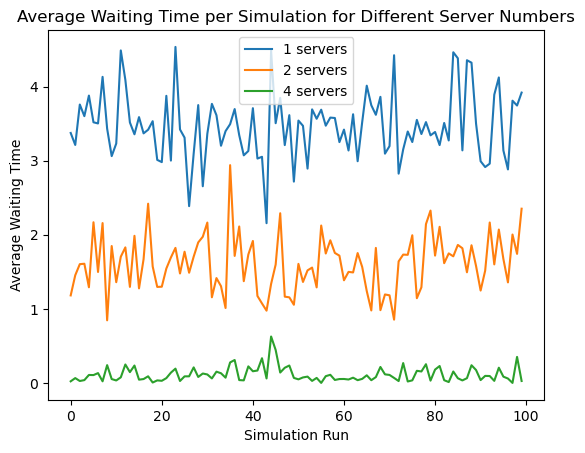

In [56]:
# Plotting average waiting times for each simulation
for num_servers, times in wait_times_data.items():
    plt.plot(times, label=f'{num_servers} servers')

plt.xlabel('Simulation Run')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time per Simulation for Different Server Numbers')
plt.legend()
plt.show()

Servers: 1, Average Waiting Time: 5.01, Std Dev: 0.39, 95% CI: (4.934268995590412, 5.0903532484290475)
Servers: 2, Average Waiting Time: 2.07, Std Dev: 0.37, 95% CI: (1.9995733506297289, 2.1471078053326655)
Servers: 3, Average Waiting Time: 0.52, Std Dev: 0.20, 95% CI: (0.48510181904636296, 0.5648504093321405)
Servers: 4, Average Waiting Time: 0.11, Std Dev: 0.08, 95% CI: (0.09183562928356051, 0.12458835055839218)
Servers: 5, Average Waiting Time: 0.02, Std Dev: 0.03, 95% CI: (0.01572223810177098, 0.0293852595565222)
Servers: 6, Average Waiting Time: 0.01, Std Dev: 0.01, 95% CI: (0.002374591377115183, 0.007756768705460696)
Servers: 7, Average Waiting Time: 0.00, Std Dev: 0.00, 95% CI: (-0.00010474600507039968, 0.0017070530326910678)
Servers: 8, Average Waiting Time: 0.00, Std Dev: 0.00, 95% CI: (-5.103893408585834e-05, 0.000154753738037613)


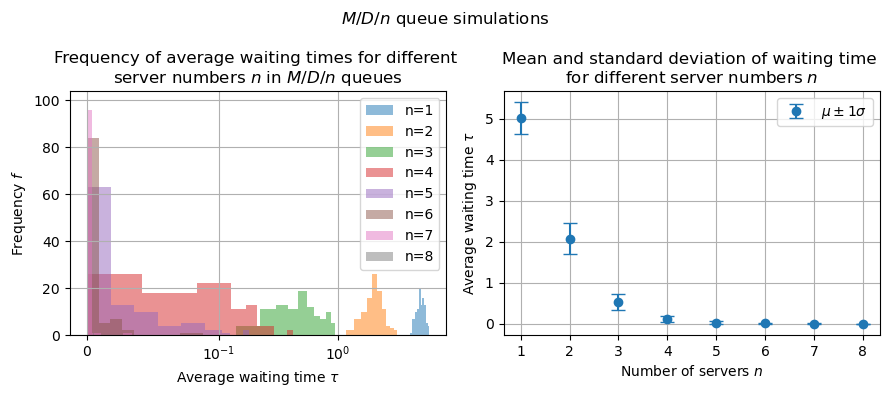

In [77]:
def simulate_experiments(dist_src='exp', dist_cst='exp', ns=[1, 2, 4]):
    """Run the simulations with provided parameters and return the average waiting times"""
    wait_times_data = {n: [] for n in ns}
    for n in ns:
        for i in range(SIMULATIONS):
            random.seed(RANDOM_SEED+i) # Same seed for reproducibility
            env = simpy.Environment()
            counter = simpy.Resource(env, capacity=n)
            wait_times = []
            env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, wait_times, dist_src=dist_src, dist_cst=dist_cst))
            env.run()
            wait_times_data[n].append(np.mean(wait_times))
    return wait_times_data

def get_statistics(wait_times_data, print_results=True):
    """Calculate average, standard deviation, and 95% confidence interval for each simulation"""
    avgs, stds, conf_intervals = [], [], []
    for num_servers, times in wait_times_data.items():
        avg_wait_time = np.mean(times)
        avgs.append(avg_wait_time)
        std_dev = np.std(times)
        stds.append(std_dev)
        conf_interval = st.t.interval(0.95, len(times)-1, loc=avg_wait_time, scale=st.sem(times))
        conf_intervals.append(conf_interval)
        if print_results:
            print(f'Servers: {num_servers}, Average Waiting Time: {avg_wait_time:.2f}, Std Dev: {std_dev:.2f}, 95% CI: {conf_interval}')
    return avgs, stds, conf_intervals

ns = np.arange(1, 9, 1, dtype=int)
wait_times_data = simulate_experiments(dist_src='exp', dist_cst='const', ns=ns)
avgs, stds, conf_intervals = get_statistics(wait_times_data)

plt.figure(figsize=(9, 4), layout='tight')
plt.suptitle('$M/D/n$ queue simulations')
plt.subplot(1, 2, 1)
for num_servers, times in wait_times_data.items():
    plt.hist(times, label=f'n={num_servers}', alpha=0.5)
plt.xlabel('Average waiting time $\\tau$')
plt.xscale('symlog', linthresh=0.1)
plt.ylabel('Frequency $f$')
plt.title('Frequency of average waiting times for different \n' +
          'server numbers $n$ in $M/D/n$ queues')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.errorbar(ns, avgs, yerr=stds, fmt='o', capsize=5, label='$\\mu \\pm 1\\sigma$')
plt.xlabel('Number of servers $n$')
plt.ylabel('Average waiting time $\\tau$')
plt.title('Mean and standard deviation of waiting time \n' + 
          'for different server numbers $n$')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
import heapq
from scipy import stats
from scipy.stats import t, sem

# Constants
RANDOM_SEED = 42
NEW_CUSTOMERS = 200
INTERVAL_CUSTOMERS = 10.0
SIMULATIONS = 100 # Min service time
SERVICE_TIME = 12.0  # Max service time for FIFO (can be any arbitrary value)

class SJFPriorityResource(simpy.PriorityResource):
    def _do_put(self, event):
        heapq.heappush(self.queue, (event.priority, next(self._put_counters), event))

def customer(env, name, counter, service_time, wait_times, priority):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    if priority:
        with counter.request(priority=service_time) as req:  # Use service time as priority
            yield req
            wait = env.now - arrive
            yield env.timeout(service_time)
            wait_times.append(wait)
    else:
        with counter.request() as req:  # No priority
            yield req
            wait = env.now - arrive
            yield env.timeout(service_time)
            wait_times.append(wait)

def source(env, number, interval, counter, wait_times, priority):
    for i in range(number):
        service_time = random.expovariate(1.0 / SERVICE_TIME)
        c = customer(env, f'Customer{i:03d}', counter, service_time, wait_times, priority)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)

def run_simulation(num_servers, priority):
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    if priority:
        # Use SimPy's PriorityResource directly
        counter = simpy.PriorityResource(env, capacity=num_servers)
    else:
        counter = simpy.Resource(env, capacity=num_servers)
    wait_times = []
    env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter, wait_times, priority))
    env.run()
    return wait_times

# Run simulations for FIFO and SJF scheduling
print('Running FIFO simulation...')
wait_times_fifo = run_simulation(1, priority=False)
print(f'FIFO Average Wait Time: {np.mean(wait_times_fifo):.2f}, Std Dev: {np.std(wait_times_fifo):.2f}, 95% CI: {t.interval(0.95, len(wait_times_fifo)-1, loc=np.mean(wait_times_fifo), scale=sem(wait_times_fifo))}')

print('Running SJF simulation...')
wait_times_sjf = run_simulation(1, priority=True)
print(f'SJF Average Wait Time: {np.mean(wait_times_sjf):.2f}, Std Dev: {np.std(wait_times_sjf):.2f}, 95% CI: {t.interval(0.95, len(wait_times_sjf)-1, loc=np.mean(wait_times_sjf), scale=sem(wait_times_sjf))}')

Running FIFO simulation...
FIFO Average Wait Time: 376.78, Std Dev: 167.22, 95% CI: (353.40907457119334, 400.15879141648014)
Running SJF simulation...
SJF Average Wait Time: 97.49, Std Dev: 308.59, 95% CI: (54.35396384171101, 140.6272602165355)


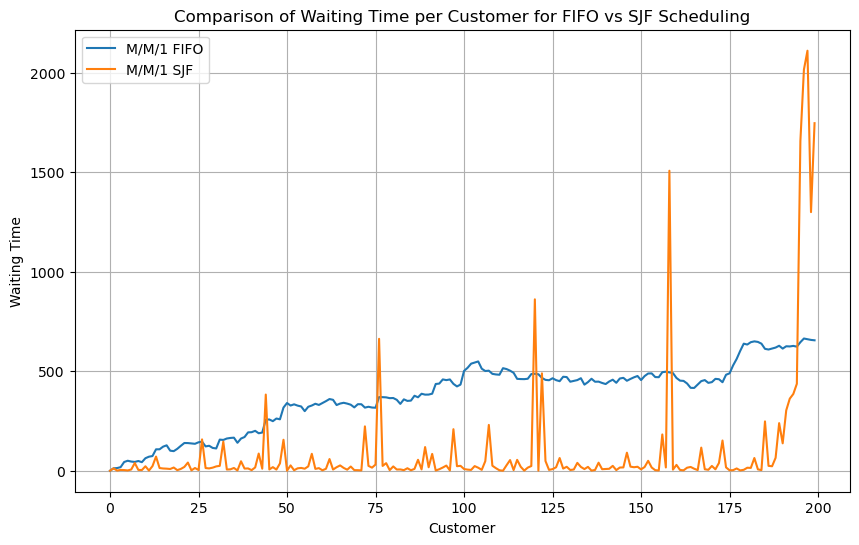

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(wait_times_fifo, label='M/M/1 FIFO')
plt.plot(wait_times_sjf, label='M/M/1 SJF')
plt.xlabel('Customer')
plt.ylabel('Waiting Time')
plt.title('Comparison of Waiting Time per Customer for FIFO vs SJF Scheduling')
plt.legend()
plt.grid(True)
plt.show()

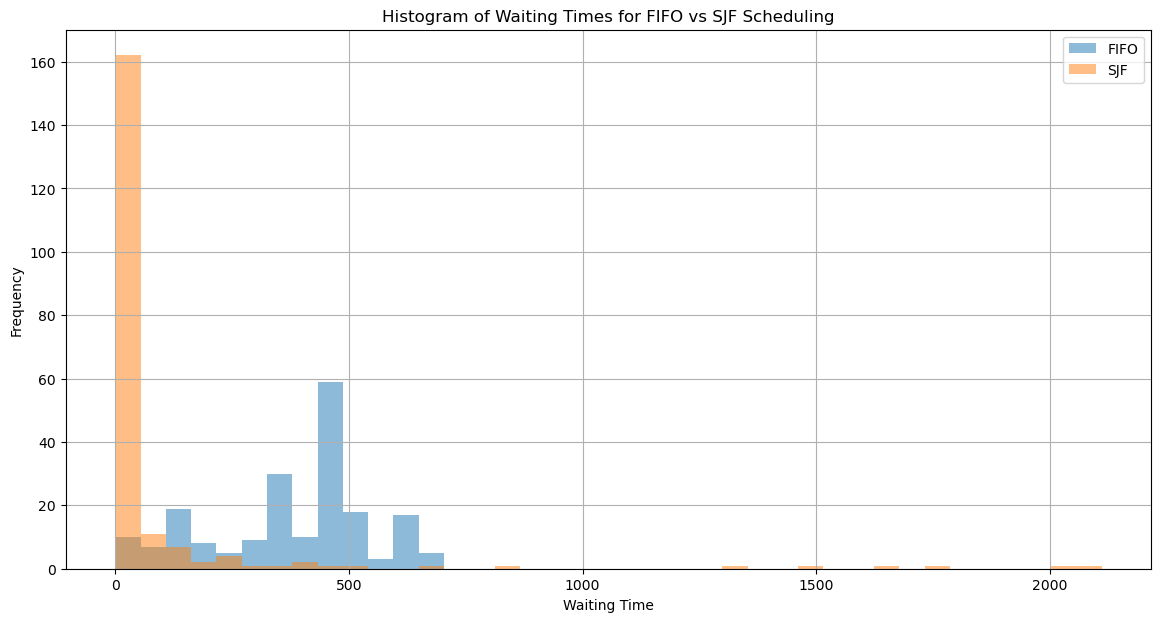

In [ ]:
# Histogram settings
bins = np.linspace(0, max(max(wait_times_fifo), max(wait_times_sjf)), 40)

plt.figure(figsize=(14, 7))

# FIFO Histogram
plt.hist(wait_times_fifo, bins, alpha=0.5, label='FIFO')

# SJF Histogram
plt.hist(wait_times_sjf, bins, alpha=0.5, label='SJF')

plt.xlabel('Waiting Time')
plt.ylabel('Frequency')
plt.title('Histogram of Waiting Times for FIFO vs SJF Scheduling')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Task 4

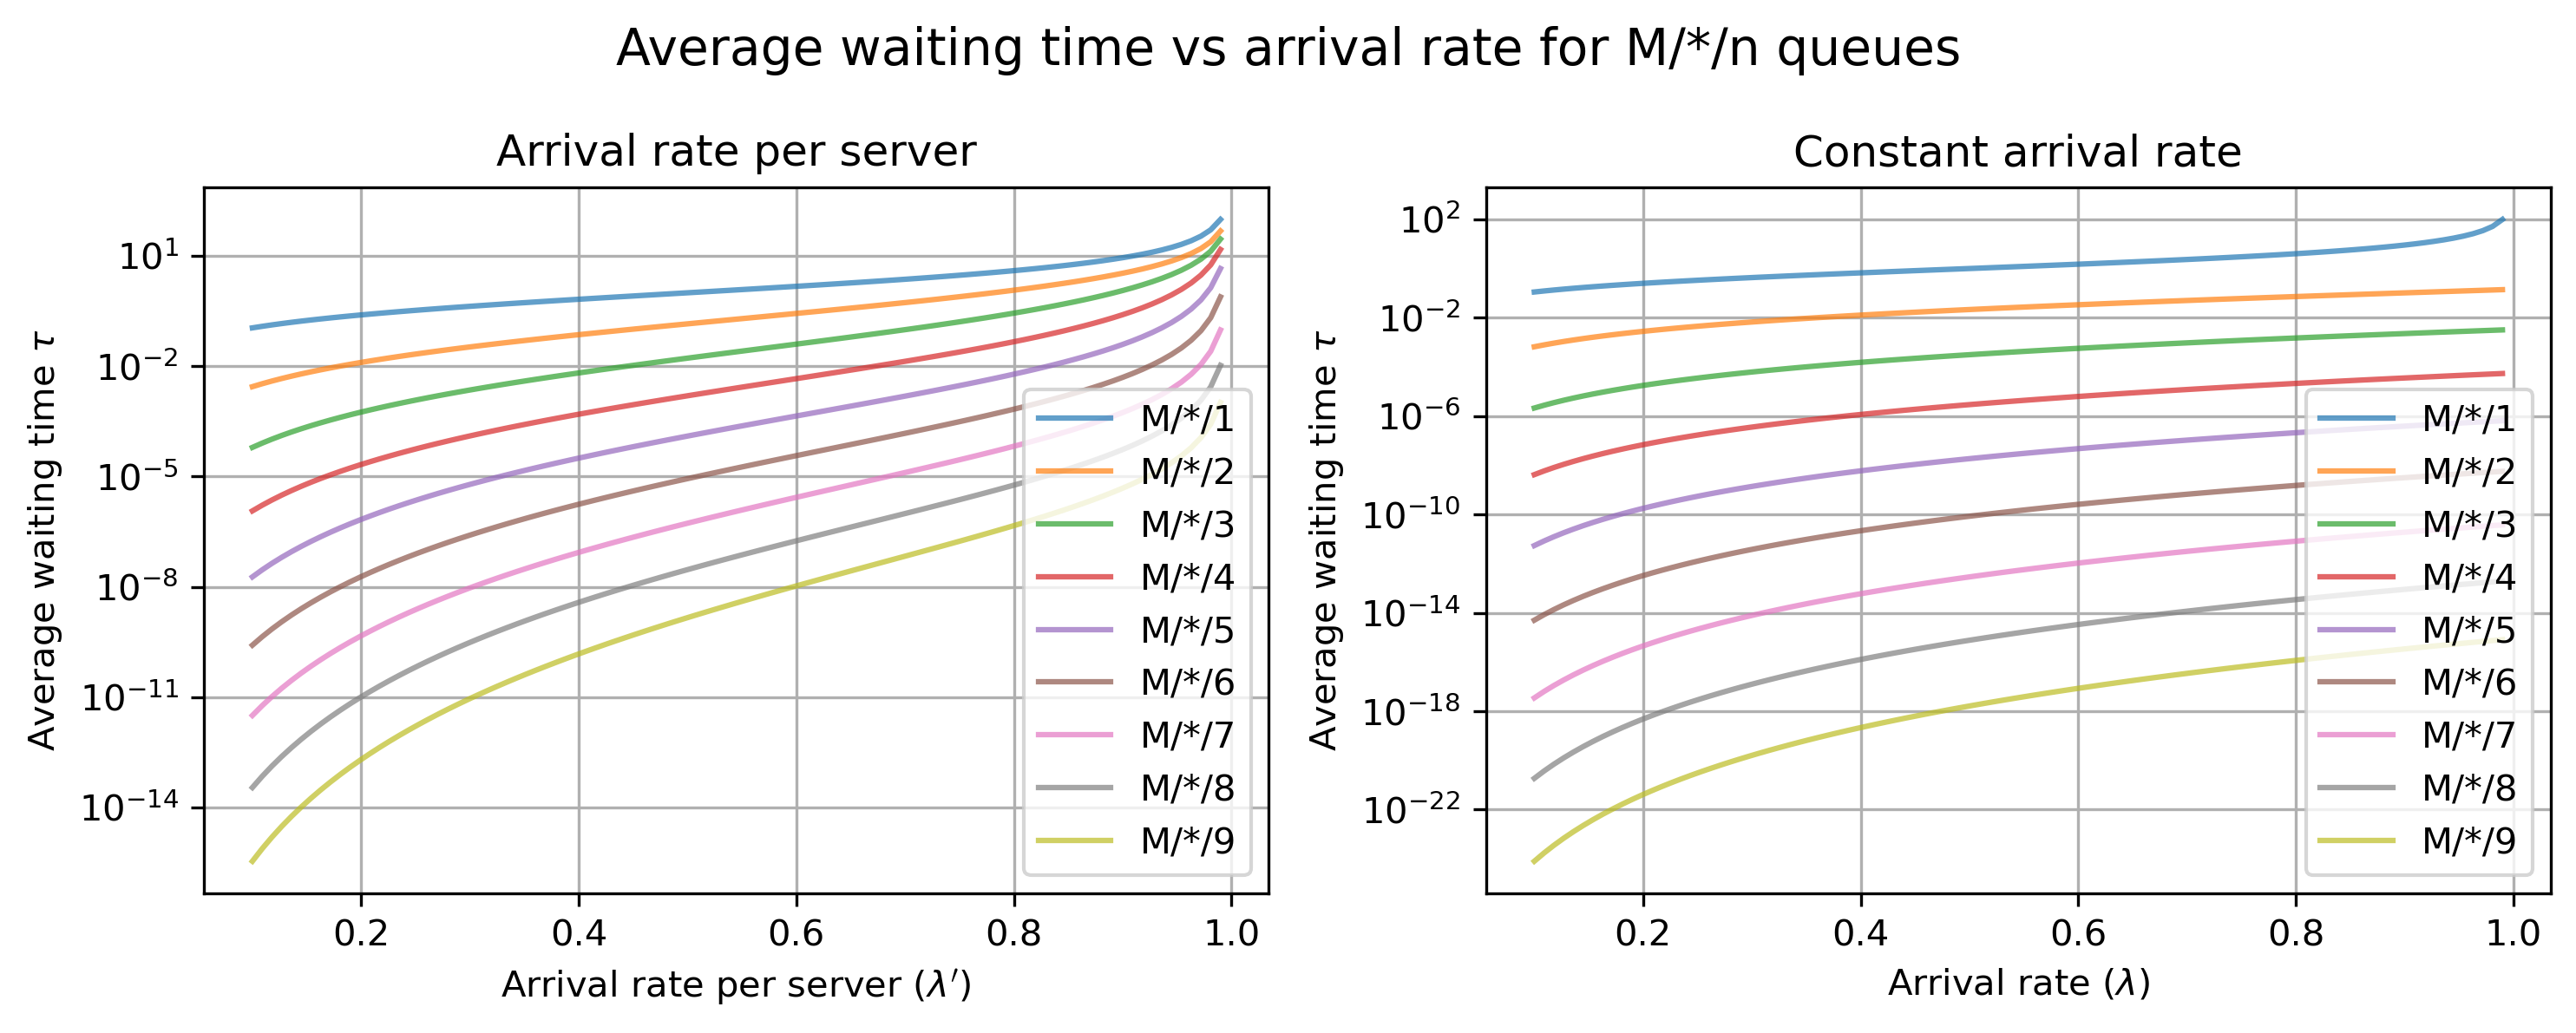

In [ ]:
ns = np.arange(1, 10, dtype=int)
# Calculate waiting times for each value of lambda
waiting_times_mxns_pserv = {n: [] for n in ns}
waiting_times_mxns = {n: [] for n in ns}
for n in ns:
    waiting_times_mxns_pserv[n] = [mxn_queue(lambda_rate*n, mu, n)[0] for lambda_rate in lambda_rates]
    waiting_times_mxns[n] = [mxn_queue(lambda_rate, mu, n)[0] for lambda_rate in lambda_rates]
waiting_times_mx1 = [mx1_queue(lambda_rate, mu)[0] for lambda_rate in lambda_rates]

# Plotting
plt.figure(figsize=(10, 4), dpi=300, layout='tight')
plt.suptitle('Average waiting time vs arrival rate for M/*/n queues', fontsize=14)
plt.subplot(1, 2, 1)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns_pserv[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate per server ($\\lambda\'$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Arrival rate per server')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
for n in ns:
    plt.plot(lambda_rates, waiting_times_mxns[n], label=f'M/*/{n}', alpha=0.7)
plt.xlabel('Arrival rate ($\\lambda$)')
plt.ylabel('Average waiting time $\\tau$')
plt.yscale('log')
plt.title('Constant arrival rate')
plt.legend()
plt.grid(True)
plt.show()